# Pairs Trading Strategy on SPY and IVV

This notebook demonstrates a pairs trading strategy based on cointegration between two ETFs: SPY and IVV.

We will:

- Download historical price data
- Test for cointegration using the Johansen test
- Calculate the spread and z-score
- Implement entry and exit signals based on the spread's z-score
- Track portfolio value and evaluate performance metrics


## Parameters and Setup

- Training period: 2012-01-01 to 2019-01-01  
- Testing period: 2019-01-01 to 2023-01-01  
- Stocks: SPY and IVV  
- Capital: $1,000,000  
- Entry z-score threshold: 1.0  
- Exit z-score threshold: 0.5  
- Transaction cost: $0.01 per share traded


In [22]:
# Params
train_start, train_end = '2012-01-01', '2019-01-01'
test_start, test_end = '2019-01-01', '2023-01-01'
stock1, stock2 = 'SPY', 'IVV'
capital = 1_000_000
entry_z = 1.0
exit_z = 0.5
transaction_cost_per_share = 0.01  # assume 1 cent per share per trade


## Downloading Price Data

We use `yfinance` to download adjusted close prices for SPY and IVV in the specified train and test periods.


In [23]:
def download_data(ticker, start, end):
    return yf.download(ticker, start=start, end=end, auto_adjust=True)['Close']

train1 = download_data(stock1, train_start, train_end)
train2 = download_data(stock2, train_start, train_end)
test1 = download_data(stock1, test_start, test_end)
test2 = download_data(stock2, test_start, test_end)

train = pd.concat([train1, train2], axis=1).dropna()
test = pd.concat([test1, test2], axis=1).dropna()
train.columns = test.columns = [stock1, stock2]


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Cointegration Test

We perform the Johansen cointegration test on the log prices to confirm that SPY and IVV have a stable long-term relationship.

If cointegration is detected, we calculate the hedge ratio from the eigenvector.


In [24]:
log_prices = np.log(train)
johansen_test = coint_johansen(log_prices, det_order=0, k_ar_diff=1)

if johansen_test.lr1[0] > johansen_test.cvt[0, 1]:
    hedge_ratio = johansen_test.evec[0,0] / johansen_test.evec[1,0]
    print(f"Cointegration CONFIRMED | Hedge Ratio: {hedge_ratio:.4f}")
else:
    raise Exception("No cointegration detected")


Cointegration CONFIRMED | Hedge Ratio: -0.9958


## Calculate Spread and Z-score on Training Data

The spread is defined as:

\[
\text{Spread} = \text{Price}_\text{SPY} - \text{Hedge Ratio} \times \text{Price}_\text{IVV}
\]

We calculate the rolling mean and standard deviation of the spread over a 21-day window, then compute the z-score.


In [25]:
window = 21
train['Spread'] = train[stock1] - hedge_ratio * train[stock2]
train['Mean'] = train['Spread'].rolling(window).mean()
train['Std'] = train['Spread'].rolling(window).std()
train['Z'] = (train['Spread'] - train['Mean']) / train['Std']


## Apply Spread and Z-score Calculation to Test Data

For the test period, we apply the spread calculation and use the last rolling mean and standard deviation from the training period to compute z-scores.


In [26]:
mean_spread = train['Mean'].iloc[-1]
std_spread = train['Std'].iloc[-1]

test['Spread'] = test[stock1] - hedge_ratio * test[stock2]
test['Z'] = (test['Spread'] - mean_spread) / std_spread


## Trading Logic

We define positions as:

- `1` : Long spread (long SPY, short IVV)
- `-1`: Short spread (short SPY, long IVV)
- `0` : No position

**Entry Rules:**

- Enter a short spread when z-score crosses below +1.0 from above
- Enter a long spread when z-score crosses above -1.0 from below

**Exit Rules:**

- Exit long spread when z-score crosses above -0.5
- Exit short spread when z-score crosses below +0.5

Transaction costs are subtracted at entry and exit.


In [28]:
position = 0  # 1 = long spread, -1 = short spread, 0 = flat
positions_stock1 = 0
positions_stock2 = 0
cash = capital
portfolio_values = []
trade_log = []
entry_date = None
entry_price_stock1 = None
entry_price_stock2 = None

for i in range(1, len(test)):
    date = test.index[i]
    z = test['Z'].iloc[i]
    prev_z = test['Z'].iloc[i-1]
    price1 = test[stock1].iloc[i]
    price2 = test[stock2].iloc[i]

    # Entry conditions
    if position == 0:
        if prev_z > entry_z and z <= entry_z:
            # Short spread: short stock1, long stock2
            shares1 = int((capital/2) / price1)
            shares2 = int((capital/2) / price2)
            position = -1
            positions_stock1 = -shares1
            positions_stock2 = shares2
            entry_date = date
            entry_price_stock1 = price1
            entry_price_stock2 = price2
            cost = (shares1 + shares2) * transaction_cost_per_share
            cash -= cost
            trade_log.append((entry_date, None, 'Short', shares1, shares2, cost))
        elif prev_z < -entry_z and z >= -entry_z:
            # Long spread: long stock1, short stock2
            shares1 = int((capital/2) / price1)
            shares2 = int((capital/2) / price2)
            position = 1
            positions_stock1 = shares1
            positions_stock2 = -shares2
            entry_date = date
            entry_price_stock1 = price1
            entry_price_stock2 = price2
            cost = (shares1 + shares2) * transaction_cost_per_share
            cash -= cost
            trade_log.append((entry_date, None, 'Long', shares1, shares2, cost))

    # Exit conditions
    elif position == 1 and z >= -exit_z:
        exit_date = date
        exit_price_stock1 = price1
        exit_price_stock2 = price2
        pnl = (exit_price_stock1 - entry_price_stock1) * positions_stock1 + \
              (entry_price_stock2 - exit_price_stock2) * (-positions_stock2)
        cost = (abs(positions_stock1) + abs(positions_stock2)) * transaction_cost_per_share
        cash += pnl - cost
        trade_log[-1] = trade_log[-1][:-1] + (exit_date, pnl, cost)
        position = 0
        positions_stock1 = 0
        positions_stock2 = 0

    elif position == -1 and z <= exit_z:
        exit_date = date
        exit_price_stock1 = price1
        exit_price_stock2 = price2
        pnl = (entry_price_stock1 - exit_price_stock1) * (-positions_stock1) + \
              (exit_price_stock2 - entry_price_stock2) * positions_stock2
        cost = (abs(positions_stock1) + abs(positions_stock2)) * transaction_cost_per_share
        cash += pnl - cost
        trade_log[-1] = trade_log[-1][:-1] + (exit_date, pnl, cost)
        position = 0
        positions_stock1 = 0
        positions_stock2 = 0

    # Portfolio value = cash + market value of open positions
    market_value = cash + positions_stock1 * price1 + positions_stock2 * price2
    portfolio_values.append((date, market_value))


## Portfolio Performance

We calculate the portfolio's daily returns, Sharpe ratio, maximum drawdown, and win rate.


In [29]:
pf_df = pd.DataFrame(portfolio_values, columns=['Date', 'PortfolioValue']).set_index('Date')
pf_df['Returns'] = pf_df['PortfolioValue'].pct_change().fillna(0)

sharpe = np.sqrt(252) * pf_df['Returns'].mean() / pf_df['Returns'].std() if pf_df['Returns'].std() > 0 else 0
drawdown = (pf_df['PortfolioValue'] - pf_df['PortfolioValue'].cummax()) / pf_df['PortfolioValue'].cummax()
max_dd = drawdown.min()

wins = [trade[6] for trade in trade_log if trade[6] is not None and trade[6] > 0]
win_rate = len(wins) / len([trade for trade in trade_log if trade[6] is not None]) if trade_log else 0

print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {max_dd:.2%}")
print(f"Win Rate: {win_rate:.2%}")


Sharpe Ratio: 0.24
Max Drawdown: -0.36%
Win Rate: 66.67%


## Plot Portfolio Value

Visualize the portfolio value over the test period.


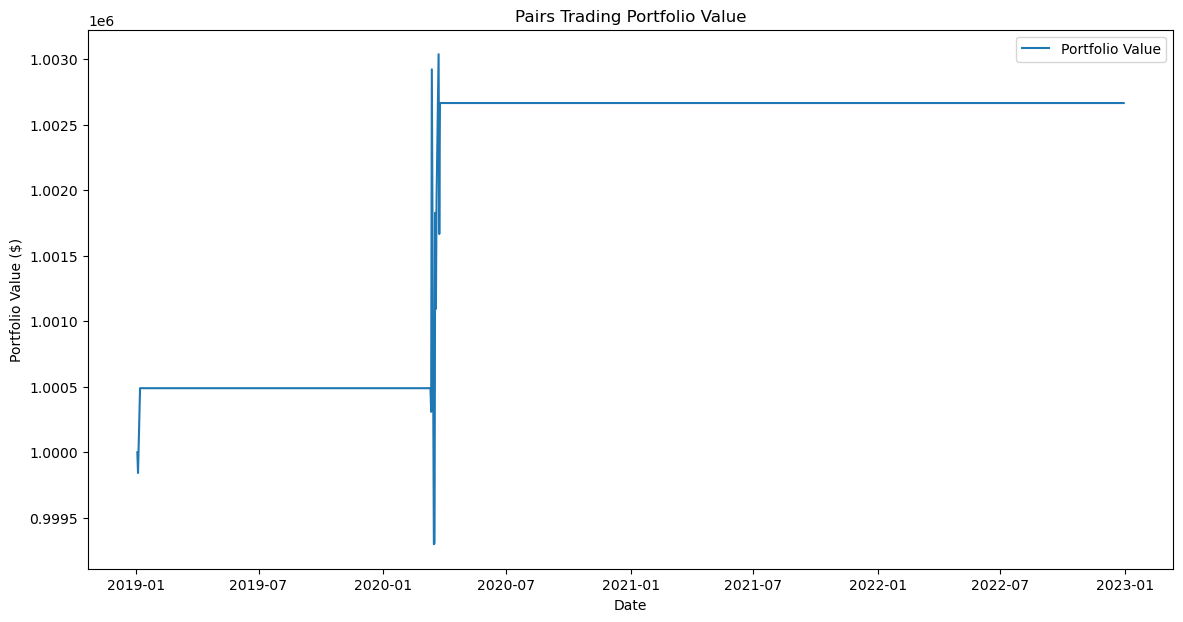

In [30]:
plt.figure(figsize=(14, 7))
plt.plot(pf_df.index, pf_df['PortfolioValue'], label='Portfolio Value')
plt.title("Pairs Trading Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()
